<a href="https://colab.research.google.com/github/grommitt/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module4-databackedassertions/Greg_Shaughn_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
#y = "health outcome" - predicted variable - dependent variable
#x = "drug usage" - explanatory variable - independent variable

# Correlation is not Causation
# tylervigen.com/spurious-correlations



In [0]:
!pip install pandas==0.23.4

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=488.0730323896484, mobile=False), User(purchased=False, time_on_site=283.0371909229164, mobile=True), User(purchased=False, time_on_site=159.82370365032799, mobile=False), User(purchased=False, time_on_site=151.9623905615802, mobile=True), User(purchased=True, time_on_site=253.61814973535354, mobile=True), User(purchased=False, time_on_site=154.28553300366988, mobile=True), User(purchased=True, time_on_site=42.68513486035761, mobile=False), User(purchased=False, time_on_site=220.53274754575645, mobile=True), User(purchased=True, time_on_site=293.64961483174136, mobile=True), User(purchased=True, time_on_site=117.40178962282613, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,488.073032,False
1,False,283.037191,True
2,False,159.823704,False
3,False,151.962391,True
4,True,253.618150,True


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.0173752468308415,5.051502085017773,5.10471166681775,5.307792409426391,5.683237445884413,5.763140902614521,5.842085290380598,6.762123139260634,6.791935874190254,7.066247689672979,...,579.3498287624847,581.3304862664481,582.2002710473639,583.2788821046878,587.9904571674363,588.6143128537541,589.8919309800247,590.0515494131328,590.4643238559228,594.8879464513018
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,0,1,1,0,0,1,1,1,1,...,0,1,0,1,0,1,1,1,1,0
True,0,1,0,0,1,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1


In [6]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.428, 122.991]","(122.991, 240.966]","(240.966, 358.94]","(358.94, 476.914]","(476.914, 594.888]"
purchased,,,,,
False,231,220,131,31,21
True,104,139,81,14,28


In [8]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.428, 122.991]","(122.991, 240.966]","(240.966, 358.94]","(358.94, 476.914]","(476.914, 594.888]"
purchased,,,,,
False,0.689552,0.612813,0.617925,0.688889,0.428571
True,0.310448,0.387187,0.382075,0.311111,0.571429


In [10]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.712,0.608
True,0.288,0.392


In [12]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], 
            rownames=['device'],
            colnames=['purchased', 'time on site'],
            normalize='index')
ct

purchased               False                                       \
time on site (4.428, 122.991] (122.991, 240.966] (240.966, 358.94]   
device                                                               
False                   0.168              0.172             0.164   
True                    0.252              0.236             0.120   

purchased                                                    True   \
time on site (358.94, 476.914] (476.914, 594.888] (4.428, 122.991]   
device                                                               
False                    0.124              0.084            0.032   
True                     0.000              0.000            0.128   

purchased                                                            \
time on site (122.991, 240.966] (240.966, 358.94] (358.94, 476.914]   
device                                                                
False                  0.044000          0.044000             0.056   
True                   0.170667          0.093333             0.000   

purchased                        
time on site (476.914, 594.888]  
device                           
False                     0.112  
True                      0.000

In [0]:
#help(user_data.plot)

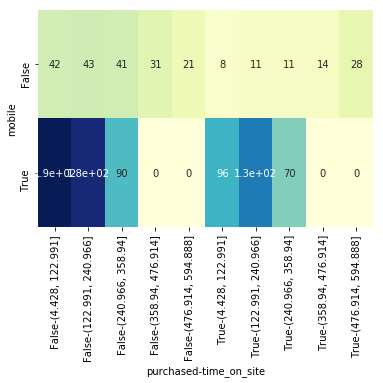

In [19]:
import seaborn as sns
sns.heatmap(pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins]),
           cmap="YlGnBu", annot=True, cbar=False)

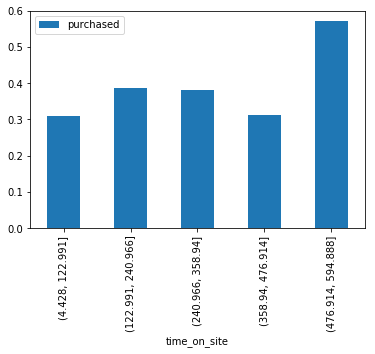

In [20]:
pd.pivot_table(user_data, values='purchased', 
              index=time_bins).plot.bar()

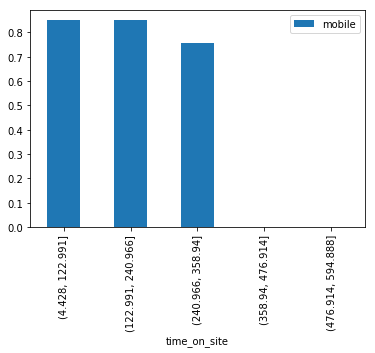

In [21]:
pd.pivot_table(
    user_data, values='mobile', index=time_bins).plot.bar();

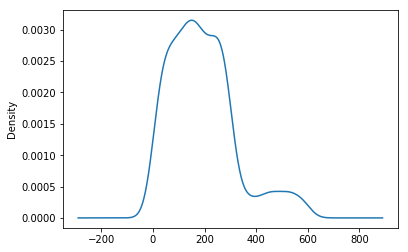

In [22]:
user_data['time_on_site'].plot.density();

In [23]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], 
                normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.428, 122.991]    0.235955  0.414474  0.111111  0.326531
(122.991, 240.966]  0.241573  0.388158  0.152778  0.435374
(240.966, 358.94]   0.230337  0.197368  0.152778  0.238095
(358.94, 476.914]   0.174157  0.000000  0.194444  0.000000
(476.914, 594.888]  0.117978  0.000000  0.388889  0.000000

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
import pandas as pd


In [0]:
persons_data = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')

In [0]:
?pd.read_csv

In [0]:
# make the first column 'unique_id' instead of 'unknown'
persons_data.columns = ['unique_id', 'age', 'weight', 'exercise_time']

In [55]:
persons_data.head(20)

,unique_id,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182
5,5,58,103,165
6,6,55,161,107
7,7,21,188,37
8,8,55,216,79
9,9,50,127,267


In [57]:
# CROSSTABULATION
pd.crosstab(persons_data['weight'], persons_data['exercise_time'])

exercise_time,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,296,297,298,299,300
weight,,,,,,,,,,,,,,,,,,,,,
100,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [79]:
# put exercise_time in discrete buckets(bins)
# use pandas.cut

exercise_time_bins = pd.cut(persons_data['exercise_time'], 5) # 8 equal sized bins
weight_bins = pd.cut(persons_data['weight'], 5)
pd.crosstab(weight_bins, exercise_time_bins)

exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
weight,,,,,
"(99.854, 129.2]",53,65,71,79,107
"(129.2, 158.4]",44,76,67,74,74
"(158.4, 187.6]",61,93,56,38,10
"(187.6, 216.8]",76,73,29,1,0
"(216.8, 246.0]",44,9,0,0,0


In [80]:
# Normalize the data (getting %)

ct = pd.crosstab(weight_bins, exercise_time_bins, normalize='columns')
ct


exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
weight,,,,,
"(99.854, 129.2]",0.190647,0.205696,0.318386,0.411458,0.560209
"(129.2, 158.4]",0.158273,0.240506,0.300448,0.385417,0.387435
"(158.4, 187.6]",0.219424,0.294304,0.251121,0.197917,0.052356
"(187.6, 216.8]",0.273381,0.231013,0.130045,0.005208,0.000000
"(216.8, 246.0]",0.158273,0.028481,0.000000,0.000000,0.000000


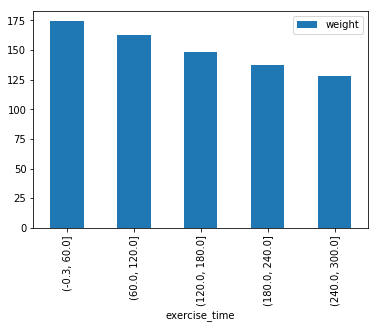

In [81]:
# visualize these results
#as weight increases, the length of exercise time decreases
pd.pivot_table(
    persons_data, values='weight', index=exercise_time_bins).plot.bar()

In [82]:
# now let's check age and exercise time
#CROSSTABULATION
pd.crosstab(persons_data['age'], persons_data['exercise_time'])

exercise_time,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,296,297,298,299,300
age,,,,,,,,,,,,,,,,,,,,,
18,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
25,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# bin it and normalize it
age_bins = pd.cut(persons_data['age'], 5)
pd.crosstab(age_bins, exercise_time_bins, normalize='columns')

exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
age,,,,,
"(17.938, 30.4]",0.187050,0.145570,0.242152,0.317708,0.225131
"(30.4, 42.8]",0.187050,0.174051,0.188341,0.244792,0.298429
"(42.8, 55.2]",0.147482,0.132911,0.174888,0.177083,0.350785
"(55.2, 67.6]",0.165468,0.224684,0.179372,0.213542,0.125654
"(67.6, 80.0]",0.312950,0.322785,0.215247,0.046875,0.000000


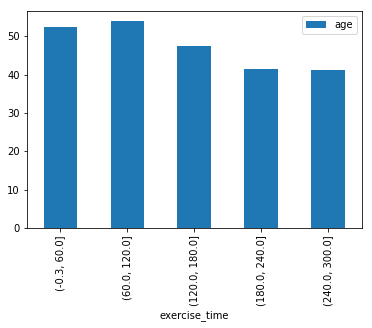

In [84]:
#  people over 50, tend to have short exercise times. People below 50 tend to have less short exercise times and more long exercise times.
pd.pivot_table(persons_data, values='age',
              index=exercise_time_bins).plot.bar()

In [88]:
# now lets try all 3 factors
pd.crosstab(exercise_time_bins, [weight_bins, age_bins], normalize='index')

weight         (99.854, 129.2]                                         \
age             (17.938, 30.4] (30.4, 42.8] (42.8, 55.2] (55.2, 67.6]   
exercise_time                                                           
(-0.3, 60.0]          0.035971     0.028777     0.025180     0.025180   
(60.0, 120.0]         0.028481     0.060127     0.018987     0.031646   
(120.0, 180.0]        0.076233     0.085202     0.040359     0.058296   
(180.0, 240.0]        0.098958     0.130208     0.093750     0.062500   
(240.0, 300.0]        0.130890     0.172775     0.198953     0.057592   

weight                      (129.2, 158.4]                            \
age            (67.6, 80.0] (17.938, 30.4] (30.4, 42.8] (42.8, 55.2]   
exercise_time                                                          
(-0.3, 60.0]       0.075540       0.025180     0.035971     0.025180   
(60.0, 120.0]      0.066456       0.047468     0.025316     0.028481   
(120.0, 180.0]     0.058296       0.089686     0.035874     0.058296   
(180.0, 240.0]     0.026042       0.151042     0.078125     0.036458   
(240.0, 300.0]     0.000000       0.078534     0.109948     0.136126   

weight                                       ...      (187.6, 216.8]  \
age            (55.2, 67.6] (67.6, 80.0]     ...      (17.938, 30.4]   
exercise_time                                ...                       
(-0.3, 60.0]       0.021583     0.050360     ...            0.061151   
(60.0, 120.0]      0.063291     0.075949     ...            0.031646   
(120.0, 180.0]     0.062780     0.053812     ...            0.031390   
(180.0, 240.0]     0.098958     0.020833     ...            0.000000   
(240.0, 300.0]     0.062827     0.000000     ...            0.000000   

weight                                                              \
age            (30.4, 42.8] (42.8, 55.2] (55.2, 67.6] (67.6, 80.0]   
exercise_time                                                        
(-0.3, 60.0]       0.061151     0.032374     0.053957     0.064748   
(60.0, 120.0]      0.037975     0.037975     0.066456     0.056962   
(120.0, 180.0]     0.008969     0.022422     0.031390     0.035874   
(180.0, 240.0]     0.000000     0.000000     0.005208     0.000000   
(240.0, 300.0]     0.000000     0.000000     0.000000     0.000000   

weight         (216.8, 246.0]                                         \
age            (17.938, 30.4] (30.4, 42.8] (42.8, 55.2] (55.2, 67.6]   
exercise_time                                                          
(-0.3, 60.0]          0.02518      0.02518     0.025180     0.028777   
(60.0, 120.0]         0.00000      0.00000     0.003165     0.003165   
(120.0, 180.0]        0.00000      0.00000     0.000000     0.000000   
(180.0, 240.0]        0.00000      0.00000     0.000000     0.000000   
(240.0, 300.0]        0.00000      0.00000     0.000000     0.000000   

weight                       
age            (67.6, 80.0]  
exercise_time                
(-0.3, 60.0]       0.053957  
(60.0, 120.0]      0.022152  
(120.0, 180.0]     0.000000  
(180.0, 240.0]     0.000000  
(240.0, 300.0]     0.000000  

[5 rows x 25 columns]

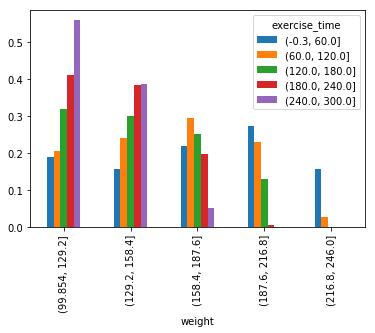

In [90]:
ct.plot(kind='bar')

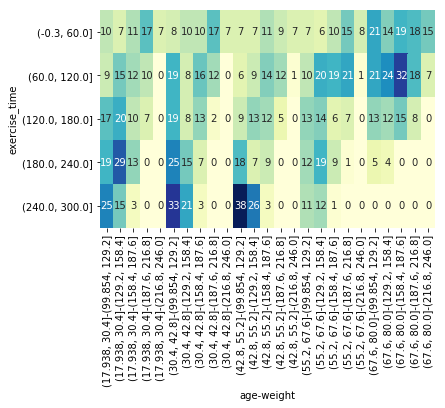

In [96]:
# people who are between the age of 42 and 55 with weight below 130 pounds have the highest exercise times.
# most likely ultra-marathon runners and triathletes.
# considering the overall average age of a Ironman Triathlete is 42.8, this makes sense.
import seaborn as sns
sns.heatmap(pd.crosstab(exercise_time_bins, [age_bins, weight_bins]),
           cmap='YlGnBu', annot=True, cbar=False)

In [99]:
# now lets try age and weight
# looks like a spurious correlation. no consistent trends.
pd.crosstab(age_bins, weight_bins, normalize='columns')

weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]"
age,,,,,
"(17.938, 30.4]",0.213333,0.256716,0.189922,0.189944,0.132075
"(30.4, 42.8]",0.277333,0.185075,0.189922,0.173184,0.132075
"(42.8, 55.2]",0.208000,0.185075,0.189922,0.145251,0.150943
"(55.2, 67.6]",0.141333,0.211940,0.174419,0.245810,0.169811
"(67.6, 80.0]",0.160000,0.161194,0.255814,0.245810,0.415094


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

**age - discrete**

**weight - discrete**

**exercise time - continuous**

2.  What are the relationships between the 
variables?

**People over 50, tend to have short exercise times. People below 50 tend to have less short exercise times and more long exercise times. **

**As weight increases, exercise time decreases.**

**People between 42 and 55 below 130 pounds have the highest exercise times.**

3.  Which relationships are "real", and which spurious?

**The relationships between weight/exercise time and age/exercise time are real because of the consistent patterns shown in the data.**

**The relationship between age and weight are spurious because there is no consistent pattern between age and weight. **


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)